In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from wrf import getvar, to_np, latlon_coords, ALL_TIMES, xy_to_ll,extract_times
import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import Hodograph
from pathlib import Path
import sys
import warnings
warnings.filterwarnings('ignore')
# --- CONFIGURATION (Adjust Paths as needed) ---

REPO_ROOT = Path.cwd().parents[0] if (Path.cwd().name == 'notebooks') else Path.cwd()
SRC = REPO_ROOT / 'src'
sys.path.append(str(SRC))

try:
    from core.sounding_generator import (generate_sounding,
                                         read_input_sounding, 
                                         write_input_sounding,
                                         calculate_diagnostics)
    from core.plot_utils import prepare_skewt_hodograph, plot_sounding,plot_sounding_full
except ImportError:
    print("ERROR: Could not import 'sounding_generator'.")
    print("Make sure 'sounding_generator.py' exists in the 'src/core/' directory.")
    sys.exit(1)
# --- Configuration ---
CONFIG_FILE = f'{REPO_ROOT}/configs/experiment_config.yaml'
# ---------------- User settings ----------------



/home/jorge.gacitua/salidas/miniconda3/envs/wrf-sensitivity/lib/python3.11/site-packages/wrf/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
def open_wrfs(paths):
    """Open WRF outputs as netCDF4 Datasets."""
    return [Dataset(str(p), "r") for p in paths]

def time_minutes_from_start(nc_list):
    """Return cumulative minutes for ALL_TIMES across files from first time as t=0."""
    # Gather times from all files
    times = []
    for nc in nc_list:
        t = getvar(nc, "Times", timeidx=ALL_TIMES)
        # convert to numpy datetime64 from byte strings
        times_file = np.array([np.datetime64("".join(s.astype(str))) for s in to_np(t)])
        times.extend(times_file.tolist())

    times = np.array(times, dtype="datetime64[s]")
    minutes = (times - times[0]) / np.timedelta64(1, "m")
    return times, minutes.astype(float)

def select_time_indices(target_minutes, minutes_array):
    """Map desired minutes (float) to nearest available time index."""
    idxs = []
    for m in target_minutes:
        idx = int(np.argmin(np.abs(minutes_array - m)))
        idxs.append(idx)
    return idxs

def get_field_at_global_index(nc_list, global_t_index, varname):
    """Get a variable at a global time index across possibly multiple files."""
    # Determine which file contains this global index
    count = 0
    for nc in nc_list:
        t_here = getvar(nc, "Times", timeidx=ALL_TIMES)
        nt = t_here.shape[0]
        if global_t_index < count + nt:
            local_idx = global_t_index - count
            return getvar(nc, varname, timeidx=local_idx)
        count += nt
    raise IndexError("Time index out of range.")

def column_max(var3d):
    """Return max over vertical dimension for 3D var (z, y, x)."""
    return np.nanmax(to_np(var3d), axis=0)

def compute_panel_fields(nc_list, gidx):
    """Compute column-maximum reflectivity and vertical velocity at global time index."""
    dbz = get_field_at_global_index(nc_list, gidx, "dbz")  # shape (z,y,x), dBZ
    w = get_field_at_global_index(nc_list, gidx, "wa")     # vertical velocity (m s-1)
    # Column maxima
    dbz_max = column_max(dbz)
    wmax = column_max(w)
    # Coordinates
    # Try to get X/Y in km from dx, dy; if not, just use index
    try:
        dx = float(get_field_at_global_index(nc_list, gidx, "DX").values) / 1000.0
        dy = float(get_field_at_global_index(nc_list, gidx, "DY").values) / 1000.0
    except Exception:
        dx = dy = 1.0  # km
    ny, nx = dbz_max.shape
    x = np.arange(nx) * dx
    y = np.arange(ny) * dy
    return dbz_max, wmax, x, y

def diagnostics_at_point(nc_list, gidx, ixy):
    """Compute CAPE/CIN (SFC & MU), LFC, and shear magnitudes at a grid point (iy, ix)."""
    iy, ix = ixy
    # Grab 3D state
    p = get_field_at_global_index(nc_list, gidx, "pressure")   # Pa
    t = get_field_at_global_index(nc_list, gidx, "tc") + 273.15 # K (wrf "tc" is degC)
    qv = get_field_at_global_index(nc_list, gidx, "QVAPOR")     # kg/kg
    z = get_field_at_global_index(nc_list, gidx, "z")           # m
    u = get_field_at_global_index(nc_list, gidx, "ua")          # m/s
    v = get_field_at_global_index(nc_list, gidx, "va")          # m/s

    # Extract columns (z)
    p_prof = to_np(p[:, iy, ix]) * units.pascal
    T_prof = to_np(t[:, iy, ix]) * units.kelvin
    qv_prof = to_np(qv[:, iy, ix]) * units("g/kg")
    z_prof = to_np(z[:, iy, ix]) * units.meter
    u_prof = to_np(u[:, iy, ix]) * (units.meter / units.second)
    v_prof = to_np(v[:, iy, ix]) * (units.meter / units.second)

    # Derived
    # MetPy needs monotonically decreasing pressure
    #sort_idx = np.argsort(p_prof.m, kind="mergesort")[::-1]
    sort_idx = np.argsort(p_prof, kind="mergesort")[::-1]
    p_prof = p_prof[sort_idx]
    T_prof = T_prof[sort_idx]
    qv_prof = qv_prof[sort_idx]
    z_prof = z_prof[sort_idx]
    u_prof = u_prof[sort_idx]
    v_prof = v_prof[sort_idx]

    Td_prof = mpcalc.dewpoint_from_specific_humidity(p_prof, T_prof, qv_prof)

    # Surface-based and most-unstable parcels
    try:
        cape_sfc, cin_sfc = mpcalc.cape_cin(p_prof, T_prof, Td_prof,
                                            mpcalc.parcel_profile_with_lcl(p_prof, T_prof, Td_prof)[0])
    except Exception:
        cape_sfc = np.nan * units("J/kg")
        cin_sfc = np.nan * units("J/kg")

    try:
        cape_mu, cin_mu = mpcalc.most_unstable_cape_cin(p_prof, T_prof, Td_prof)
    except Exception:
        cape_mu = np.nan * units("J/kg")
        cin_mu = np.nan * units("J/kg")

    # LFC (surface-based)
    try:
        lfc_p, lfc_T, lfc_z = mpcalc.lfc(p_prof, T_prof, Td_prof)
    except Exception:
        lfc_z = np.nan * units.meter

    # Shears (0-1, 0-3, 0-6 km)
    # Interpolate winds to fixed height above ground
    z_agl = z_prof - z_prof[0]
    target_heights = np.array([1000, 3000, 6000]) * units.meter

    def shear_mag(depth):
        try:
            u_bot = mpcalc.interpolate_1d(0 * units.meter, z_agl, u_prof)
            v_bot = mpcalc.interpolate_1d(0 * units.meter, z_agl, v_prof)
            u_top = mpcalc.interpolate_1d(depth, z_agl, u_prof)
            v_top = mpcalc.interpolate_1d(depth, z_agl, v_prof)
            du = (u_top - u_bot).to("m/s")
            dv = (v_top - v_bot).to("m/s")
            return np.hypot(du.m, dv.m) * units("m/s")
        except Exception:
            return np.nan * units("m/s")

    s01 = shear_mag(1000 * units.meter)
    s03 = shear_mag(3000 * units.meter)
    s06 = shear_mag(6000 * units.meter)

    return {
        "p": p_prof, "T": T_prof, "Td": Td_prof, "z": z_prof,
        "u": u_prof, "v": v_prof, "z_agl": z_agl,
        "CAPE_SFC": cape_sfc, "CIN_SFC": cin_sfc,
        "CAPE_MU": cape_mu, "CIN_MU": cin_mu,
        "LFC_Z": (lfc_z if 'lfc_z' in locals() else np.nan * units.meter),
        "S01": s01, "S03": s03, "S06": s06,
    }



In [ ]:
def get_max_reflectivity_field(ncfile, variable_name):
    """
    Extracts the 4D field (time, lat, lon) from the WRF file for the given variable,
    computes the maximum reflectivity per pixel over time, and returns the resulting 2D field.
    """
    # Get the full 4D field from the WRF file (time, lat, lon)
    data = to_np(getvar(ncfile, variable_name, timeidx=ALL_TIMES, method="cat"))
    print(f"Data shape for variable '{variable_name}': {data.shape}")
    # Compute the maximum reflectivity per pixel (2D field)
    return max_field

In [ ]:
sample = '01357'
WRF_FILE = f"/home/jorge.gacitua/salidas/Supercell_WRF_Sensitivity/outputs/sobol_exp_default/wrf_results/sample_{sample}/wrfout_d01_0001-01-01_00:00:00"

# Minutes from first time to plot (indices are derived from time difference)
PANEL_MINUTES = [30, 60, 90, 120, 150]
# Grid point for the hodograph & sounding (iy, ix) – choose a representative point near the storm
HODO_IXY = (75, 75)  # (iy, ix)

# Output

TITLE_PREFIX = "Max Reflectivity (shade) & Max Vertical Velocity (contours)"
RUN_LABEL = ""  # e.g., "Multi_8_vars_1000 997"

# Colormap / levels
REFL_LEVELS = np.arange(-30, 65, 5)  # dBZ
W_CONTOURS = np.array([5, 10, 15, 20, 25, 30, 35, 40])  # m/s

data = Dataset(WRF_FILE)
max_field = np.nanmax(to_np(getvar(data, 'dbz', timeidx=ALL_TIMES)), axis=0)
qgrap_field = np.nanmax(to_np(getvar(data, 'QGRAUP', timeidx=ALL_TIMES)), axis=0)
u_field = np.nanmax(to_np(getvar(data, 'ua', timeidx=ALL_TIMES)), axis=0)


In [50]:
print(max_field.max())
print(max_field.min())
print(max_field.shape)
print(qgrap_field.max())
print(qgrap_field.min())
print(qgrap_field.shape)

58.27259
-30.0
(50, 79, 79)
0.016773837
0.0
(50, 79, 79)


6
12
18
24
30


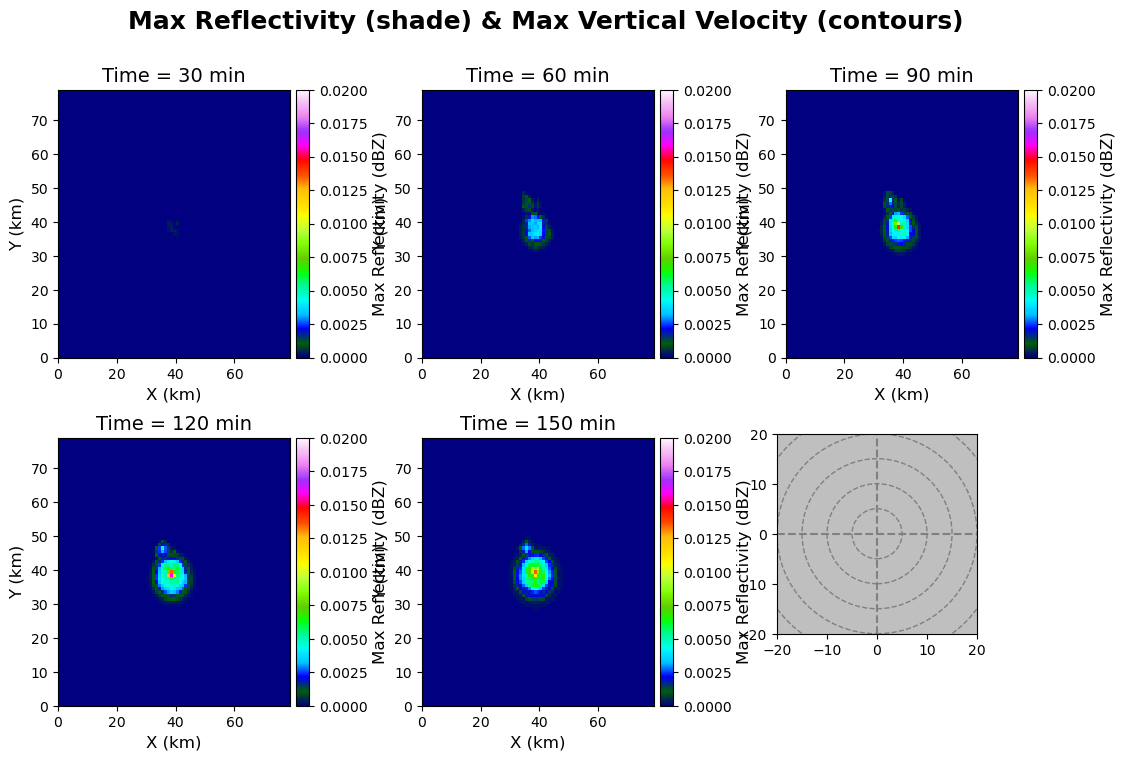

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 8))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
fig.suptitle(f"{TITLE_PREFIX}\n{RUN_LABEL}".strip(), fontsize=18, fontweight="bold", y=0.98)
axes = axes.flatten()
for i, ax in enumerate(axes):
    if i < 5:
        idx = (i+1)*6
        print(idx)
        minute = idx*5#PANEL_MINUTES[i]
        im = ax.pcolormesh(qgrap_field[idx,:,:], cmap='gist_ncar',vmin = 0, vmax = 0.02)
        cbar = fig.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
        cbar.set_label('Max Reflectivity (dBZ)', fontsize=12)
        ax.set_title(f'Time = {minute} min', fontsize=14)
        ax.set_xlabel('X (km)', fontsize=12)
        ax.set_ylabel('Y (km)', fontsize=12)
    else:
        ax.axis('off')  # Hide unused subplot
ax = fig.add_axes([0.63,0.2,0.25,0.25])
ax.set_facecolor('0.75') 
h = Hodograph(ax, component_range=20)
h.add_grid(increment=5, color = 'gray')
cmap = cm.Spectral
norm = mcolors.Normalize(vmin=0, vmax=12000)
colors = cmap(norm(interp_levels))